In [1]:
!pip install transformers datasets accelerate peft --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install evaluate bert-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.8 MB/s eta 0:00:00


# Imports and mount drive

In [3]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments,Seq2SeqTrainingArguments, DataCollatorForSeq2Seq, Seq2SeqTrainer, Trainer, pipeline
import torch
from datasets import load_dataset
import os
import evaluate
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
os.environ["WANDB_DISABLED"] = "true"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [4]:
from google.colab import drive
drive.mount('/content/drive')
import os

Mounted at /content/drive


# Finetune the model
## Load data set

In [5]:
# --- Config ---
model_name = "google/flan-t5-base"
train_data_path = "/content/drive/MyDrive/interdisc/high_risk_frames/finetune_train_data.json"
test_data_path = "/content/drive/MyDrive/interdisc/high_risk_frames/finetune_test_dataset.json"
output_dir = "/content/drive/MyDrive/interdisc/high_risk_frames/flan-t5-base-finetuned-train-159"

# Load dataset
dataset = load_dataset("json", data_files = train_data_path)["train"]
split = dataset.train_test_split(test_size=0.2, seed=42)
train_ds = split["train"]
val_ds = split["test"]
test_ds = load_dataset("json", data_files=test_data_path)["train"]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [20]:
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
from transformers import EarlyStoppingCallback
import torch

# --- Config ---
model_name = "google/flan-t5-large"
train_file = "/content/drive/MyDrive/interdisc/high_risk_frames/finetune_train_data.json"
output_dir = "/content/drive/MyDrive/interdisc/high_risk_frames/flan-t5-lora-finetuned"

# --- Load Dataset ---
dataset = load_dataset("json", data_files=train_file)["train"]
split = dataset.train_test_split(test_size=0.2, seed=42)
train_ds = split["train"]
val_ds = split["test"]

# --- Tokenizer ---
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    inputs = tokenizer(batch["prompt"], padding="max_length", truncation=True, max_length=512)
    targets = tokenizer(batch["output"], padding="max_length", truncation=True, max_length=256)
    labels = [
        [(label if label != tokenizer.pad_token_id else -100) for label in target]
        for target in targets["input_ids"]
    ]
    inputs["labels"] = labels
    return inputs

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)

# --- Load Model ---
use_fp16 = False

base_model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16 if use_fp16 else torch.float32,
    device_map="auto"
)

# --- Apply LoRA ---
lora_config = LoraConfig(
    r=4,
    lora_alpha=16,
    target_modules=["q", "v"],
    lora_dropout=0.2,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)
model = get_peft_model(base_model, lora_config)

# --- Training Arguments ---
training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    learning_rate=5e-4,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=5,
    logging_steps=10,
    predict_with_generate=True,
    fp16=use_fp16,
    report_to="none"
)

# --- Trainer ---
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model)
)

# --- Train ---
trainer.train()

# --- Save ---
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


<ipython-input-20-6ded22105a12>:74: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,2.308700
20,2.135800
30,1.960300
40,1.542600
50,1.633000
60,1.694300
70,1.639000
80,1.404600
90,1.364300
100,1.197200


('/content/drive/MyDrive/interdisc/high_risk_frames/flan-t5-lora-finetuned-test/tokenizer_config.json',
 '/content/drive/MyDrive/interdisc/high_risk_frames/flan-t5-lora-finetuned-test/special_tokens_map.json',
 '/content/drive/MyDrive/interdisc/high_risk_frames/flan-t5-lora-finetuned-test/spiece.model',
 '/content/drive/MyDrive/interdisc/high_risk_frames/flan-t5-lora-finetuned-test/added_tokens.json',
 '/content/drive/MyDrive/interdisc/high_risk_frames/flan-t5-lora-finetuned-test/tokenizer.json')

In [ ]:
# Plot loss
logs = trainer.state.log_history
loss_logs = [log for log in logs if "loss" in log]
df = pd.DataFrame(loss_logs)

plt.figure(figsize=(8, 5))
plt.plot(df["step"], df["loss"])
plt.xlabel("Step")
plt.ylabel("Training Loss")
plt.title("Training Loss over Steps")
plt.grid(True)
plt.show()

## Finetune

Map:   0%|          | 0/127 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-30-01c76fdd871d>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss
10,35.932400
20,28.656000
30,24.288000
40,19.952600
50,17.285500
60,14.324500
70,10.394100
80,6.338200
90,4.866100
100,4.283200


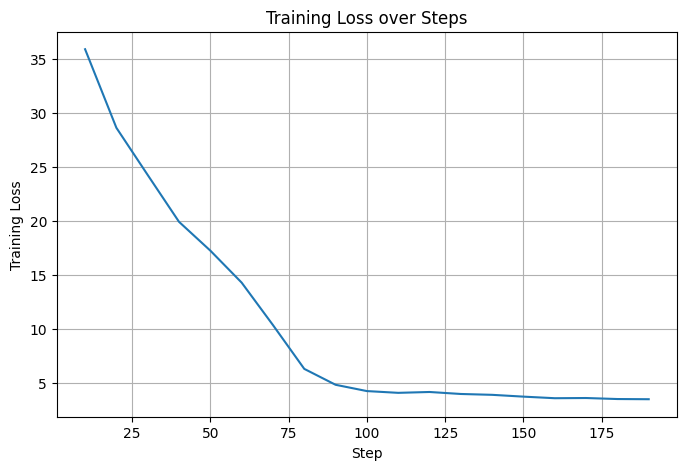

In [ ]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    inputs = tokenizer(batch["prompt"], padding="max_length", truncation=True, max_length=512)
    targets = tokenizer(batch["output"], padding="max_length", truncation=True, max_length=256)
    inputs["labels"] = targets["input_ids"]
    return inputs

# Tokenize all splits
train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)

# Model
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=10,
    predict_with_generate=True,
    fp16=True,
    save_total_limit=3,
)

torch.cuda.empty_cache()

# Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model)
)

# Train
trainer.train()

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Plot loss
logs = trainer.state.log_history
loss_logs = [log for log in logs if "loss" in log]
df = pd.DataFrame(loss_logs)

plt.figure(figsize=(8, 5))
plt.plot(df["step"], df["loss"])
plt.xlabel("Step")
plt.ylabel("Training Loss")
plt.title("Training Loss over Steps")
plt.grid(True)
plt.show()

# Evaluate on test set

In [21]:
generator = pipeline("text2text-generation", model=output_dir, tokenizer=output_dir, truncation=True, max_length=512)
bertscore = evaluate.load("bertscore")

instruction = (
   "You are an ergonomics expert. Analyze the video observations and provide a risk explanation."
    "If the posture does not present ergonomic risk, explicitly state that the posture is acceptable and no further action is needed. Avoid adding unnecessary concerns."
    "Start with a brief overview, then explain why each body part is at risk based on posture and risk factors.\n\n"
)

def evaluate_model(test_data, generation_args, mode_label):
    results = []

    for i, example in enumerate(test_data):
        full_input = instruction + example["prompt"]
        reference = example["output"].strip()

        prediction = generator(full_input, **generation_args)[0]["generated_text"].strip()
        f1 = round(bertscore.compute(predictions=[prediction], references=[reference], lang="en")["f1"][0], 4)

        results.append({
            "video_id": example["video_id"],
            "prompt": full_input,
            "reference": reference,
            "prediction": prediction,
            "bertscore_f1": f1
        })

        print(f"\n--- {mode_label.upper()} Example {i+1} ---")
        print(f"Video ID: {example['video_id']}")
        print(f"Prompt:\n{full_input}")
        print(f"Reference:\n{reference}")
        print(f"Prediction:\n{prediction}")
        print(f"BERTScore F1: {f1}")

    return pd.DataFrame(results)

# Generation configs
beam_args = {
    "max_length": 300,
    "do_sample": False,
    "num_beams": 4,
    "repetition_penalty": 1.2,
    "early_stopping": True
}

sampling_args = {
    "max_length": 300,
    "do_sample": True,
    "temperature": 0.5,
    "top_p": 0.75,
    "top_k": 15,
    "repetition_penalty": 1.2
}

sampling_args_2 = {
    "max_length": 300,
    "do_sample": True,
    "temperature": 0.7,
    "top_p": 0.85,
    "top_k": 20,
    "repetition_penalty": 1.2
}


#df_beam = evaluate_model(test_ds, beam_args, "beam")
#df_temp = evaluate_model(test_ds, sampling_args, "temp")

df_temp = evaluate_model(test_ds, sampling_args_2, "temp")

#df_beam.to_csv(f"{output_dir}/test_output_beam_search.csv", index=False)
df_temp.to_csv(f"{output_dir}/test_output_temp.csv", index=False)

Device set to use cuda:0
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- TEMP Example 1 ---
Video ID: video_11
Prompt:
You are an ergonomics expert. Analyze the video observations and provide a risk explanation.If the posture does not present ergonomic risk, explicitly state that the posture is acceptable and no further action is needed. Avoid adding unnecessary concerns.Start with a brief overview, then explain why each body part is at risk based on posture and risk factors.

Caption: there is a man that is sitting at a desk with a laptop.
Body part: upper arm left. Risk factors: moderately above shoulder level (increased strain on shoulder joint), with left shoulder elevated (Trapezius strain; muscle fatigue); abducted (Rotator cuff stress; joint instability).
Body part: upper arm right. Risk factors: moderately above shoulder level (increased strain on shoulder joint), with right shoulder elevated (Trapezius strain; muscle fatigue); abducted (Rotator cuff stress; joint instability).
Body part: forearm left. Risk factors: too extended or overly flexe